In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

from IPython.display import Image, display
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import OrdinalEncoder

In [2]:
train_df = pd.read_csv('train1.csv')

In [3]:
transactions_df = pd.read_csv('transactions1.csv')

In [4]:
stores_df = pd.read_csv('stores.csv')

In [5]:
train_df = pd.merge(train_df,stores_df,how='left',on='store_nbr')
train_df.head()

id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type  cluster  
0  Pichincha    D       13  
1  Pichincha    D       13  
2  Pichincha    D       13  
3  Pichincha    D       13  
4  Pichincha    D       13

In [6]:
oil_df = pd.read_csv('oil.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])

In [7]:
print(len(train_df.date.unique()) , len(oil_df.date.unique()))

dates_df = pd.DataFrame(train_df.date.unique(),columns=['date'])
dates_df['date'] = pd.to_datetime(dates_df['date'])
oil_df = pd.merge(dates_df, oil_df, how="left", on="date")
oil_df = oil_df.set_index('date')
oil_df.shape

1684 1218


(1684, 1)

In [8]:
print(oil_df.query('dcoilwtico != dcoilwtico'))
print(oil_df.isnull().sum())
print(oil_df.describe())

            dcoilwtico
date                  
2013-01-01         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-12         NaN
2013-01-13         NaN
...                ...
2017-07-30         NaN
2017-08-05         NaN
2017-08-06         NaN
2017-08-12         NaN
2017-08-13         NaN

[521 rows x 1 columns]
dcoilwtico    521
dtype: int64
        dcoilwtico
count  1163.000000
mean     67.925589
std      25.677366
min      26.190000
25%      46.390000
50%      53.330000
75%      95.790000
max     110.620000


In [9]:
import plotly.express as px

fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)
fig.show()

In [10]:
oil_na = oil_df.copy()
oil_na.dropna()

dcoilwtico
date                  
2013-01-02       93.14
2013-01-03       92.97
2013-01-04       93.12
2013-01-07       93.20
2013-01-08       93.21
...                ...
2017-08-09       49.59
2017-08-10       48.54
2017-08-11       48.81
2017-08-14       47.59
2017-08-15       47.57

[1163 rows x 1 columns]

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

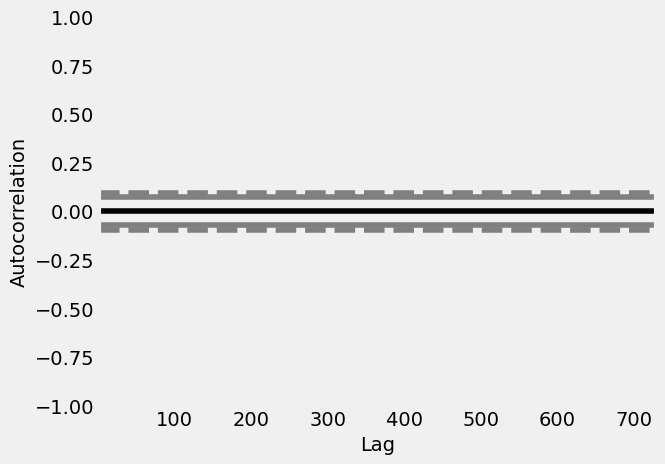

In [11]:
pd.plotting.autocorrelation_plot(oil_na['2015':'2016']['dcoilwtico'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

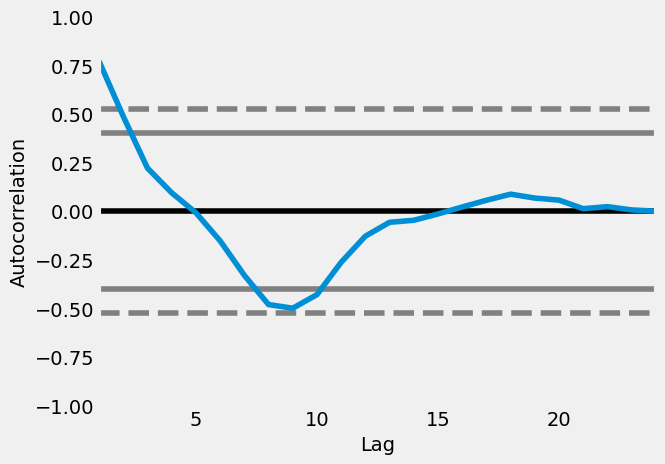

In [12]:
pd.plotting.autocorrelation_plot(oil_df['2015':'2016']['dcoilwtico'].resample('1m').mean())

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

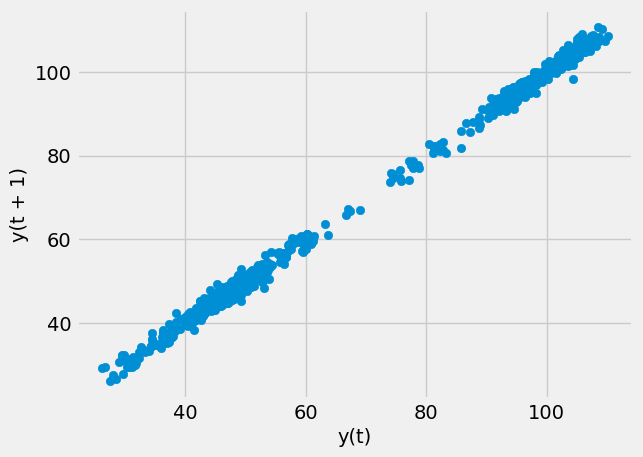

In [13]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 1)

<Axes: xlabel='y(t)', ylabel='y(t + 3)'>

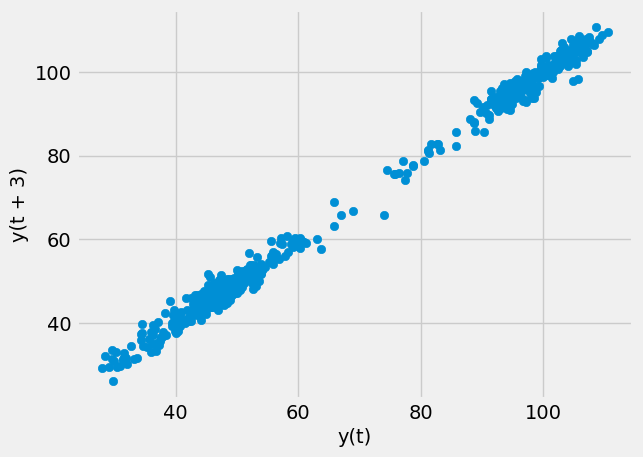

In [14]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 3)

<Axes: xlabel='y(t)', ylabel='y(t + 30)'>

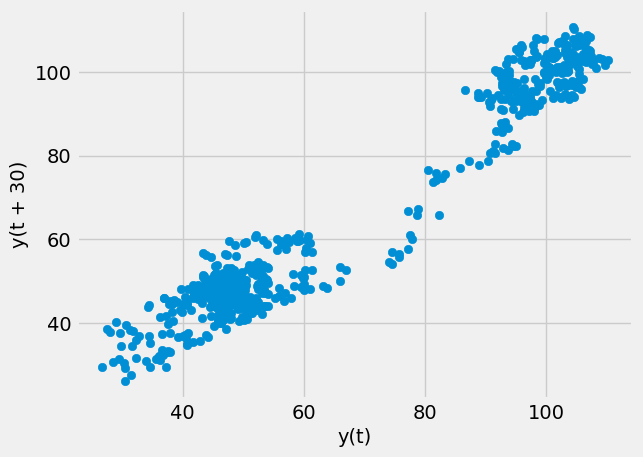

In [15]:
pd.plotting.lag_plot(oil_df['dcoilwtico'], lag= 30)

In [16]:
oil_df['dcoilwtico'][0] = oil_df['dcoilwtico'][1].copy()
oil_df = oil_df.interpolate(method='linear')

In [17]:
fig = px.line(oil_df, x = oil_df.index, y ='dcoilwtico', title='Plot slider for oil prices')
fig.update_xaxes(
    rangeslider_visible = True,
)

In [18]:
train_df['date'] = pd.to_datetime(train_df['date'])
train_df = train_df.set_index('date')

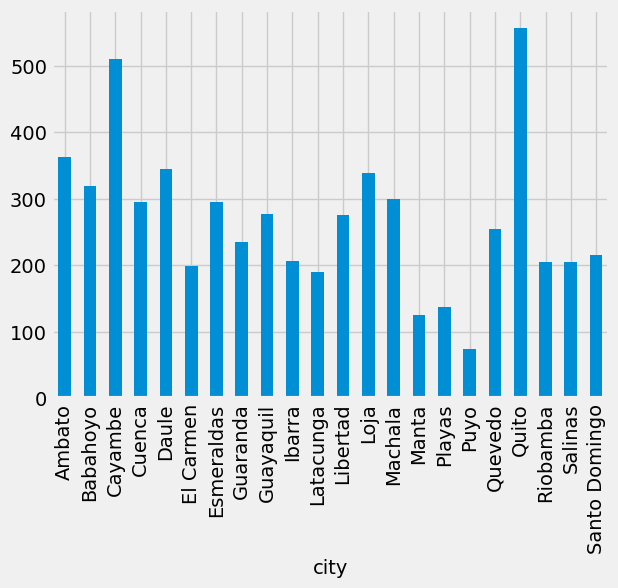

In [19]:
train_df.groupby(['city']).sales.mean().plot(kind='bar');

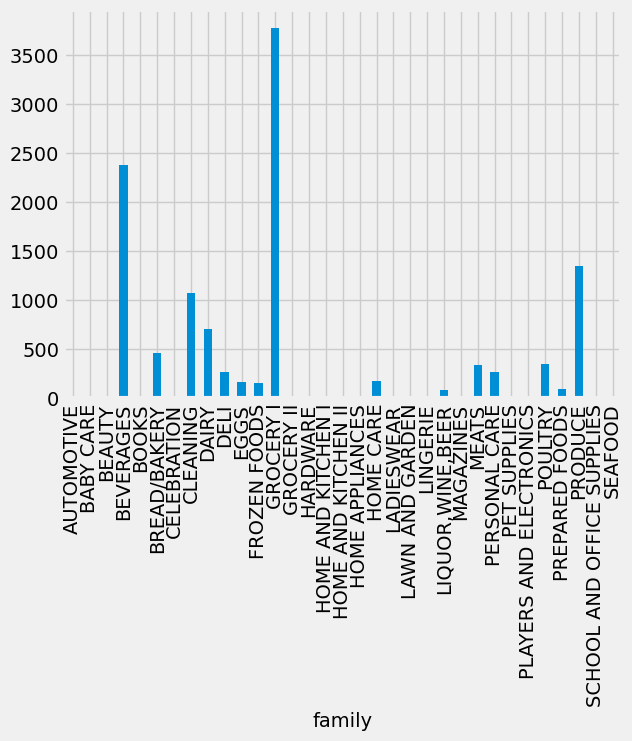

In [20]:
train_df.groupby(['family']).sales.mean().plot(kind='bar');

Text(0.5, 1.0, 'Promotion and Sales Relationship')

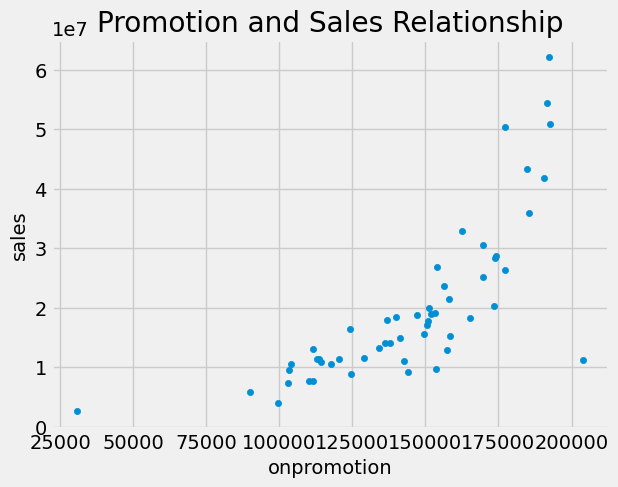

In [21]:
train_df.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales')
plt.title('Promotion and Sales Relationship')

In [22]:
train_df = pd.merge(train_df,oil_df,how='left',on='date')

In [23]:
print(train_df.query('dcoilwtico !=dcoilwtico'))

Empty DataFrame
Columns: [id, store_nbr, family, sales, onpromotion, city, state, type, cluster, dcoilwtico]
Index: []


In [24]:
grouped = train_df.groupby(['date']).agg({'dcoilwtico': 'mean', 'sales': 'mean'})
fig = px.line(grouped, x=grouped.index , y=['sales', 'dcoilwtico'])
fig.update_layout(title='Sale and Date Plot')
fig.show()
del grouped

In [25]:
train_df.head()

id  store_nbr      family  sales  onpromotion   city      state  \
date                                                                          
2013-01-01   0          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
2013-01-01   1          1   BABY CARE    0.0            0  Quito  Pichincha   
2013-01-01   2          1      BEAUTY    0.0            0  Quito  Pichincha   
2013-01-01   3          1   BEVERAGES    0.0            0  Quito  Pichincha   
2013-01-01   4          1       BOOKS    0.0            0  Quito  Pichincha   

           type  cluster  dcoilwtico  
date                                  
2013-01-01    D       13       93.14  
2013-01-01    D       13       93.14  
2013-01-01    D       13       93.14  
2013-01-01    D       13       93.14  
2013-01-01    D       13       93.14

In [26]:
holidays_df = pd.read_csv('holidays_data.csv')

holidays_df = holidays_df[holidays_df['transferred'] == False].copy()
holidays_df['holiday_type'] = holidays_df['type']
holidays_df.drop(['transferred', 'description', 'type'], axis=1, inplace=True)

national_holidays = holidays_df[holidays_df['locale'] == 'National'].copy()
national_holidays['national_holiday_type'] = national_holidays['holiday_type']
national_holidays.drop(['locale', 'locale_name', 'holiday_type'], axis=1, inplace=True)
national_holidays.drop_duplicates(subset='date', keep="first", inplace=True)
national_holidays['date'] = pd.to_datetime(national_holidays['date'])
train_df = pd.merge(train_df, national_holidays, how='left', on=['date'])


del national_holidays

train_df.head()

date  id  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01   0          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01   1          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01   2          1      BEAUTY    0.0            0  Quito  Pichincha   
3 2013-01-01   3          1   BEVERAGES    0.0            0  Quito  Pichincha   
4 2013-01-01   4          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico national_holiday_type  
0    D       13       93.14               Holiday  
1    D       13       93.14               Holiday  
2    D       13       93.14               Holiday  
3    D       13       93.14               Holiday  
4    D       13       93.14               Holiday

In [27]:
train_df.fillna('', inplace=True)

In [28]:
ordinal_encoder = OrdinalEncoder(dtype=int)
train_df[['family']] = ordinal_encoder.fit_transform(train_df[['family']])
train_df[['national_holiday_type']] = ordinal_encoder.fit_transform(train_df[['national_holiday_type']])

In [29]:
del train_df['city']
del train_df['state']
del train_df['type']
train_df.head()

date  id  store_nbr  family  sales  onpromotion  cluster  dcoilwtico  \
0 2013-01-01   0          1       0    0.0            0       13       93.14   
1 2013-01-01   1          1       1    0.0            0       13       93.14   
2 2013-01-01   2          1       2    0.0            0       13       93.14   
3 2013-01-01   3          1       3    0.0            0       13       93.14   
4 2013-01-01   4          1       4    0.0            0       13       93.14   

   national_holiday_type  
0                      4  
1                      4  
2                      4  
3                      4  
4                      4

C:\Users\amarm\AppData\Local\Temp\ipykernel_13724\4140423659.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

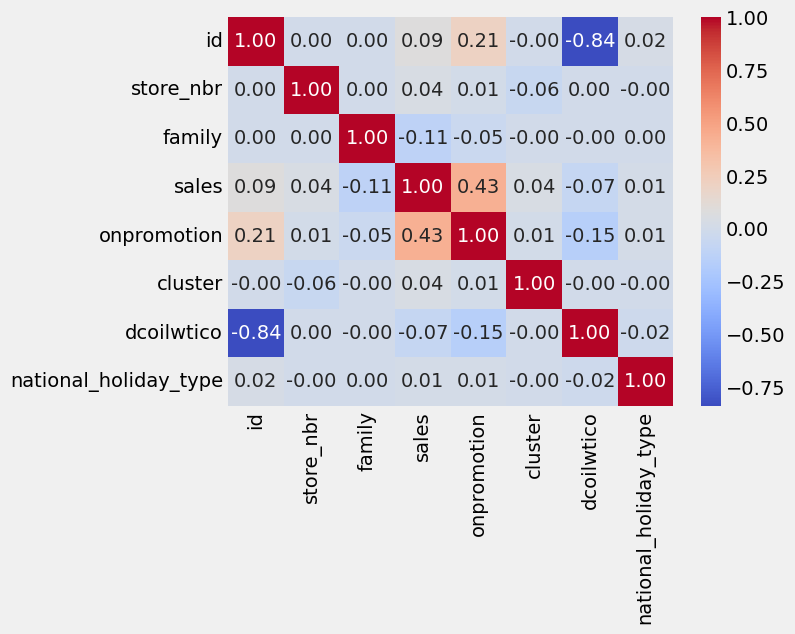

In [30]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = train_df.corr()

# Create a heatmap using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [31]:
grouped_df = train_df.groupby(['date']).agg({'sales': 'sum','dcoilwtico': 'mean', 
                                                 'onpromotion': 'sum',
                                                 'national_holiday_type': 'mean'})

grouped_df.head()

sales  dcoilwtico  onpromotion  national_holiday_type
date                                                                     
2013-01-01    2511.618999   93.140000            0                    4.0
2013-01-02  496092.417944   93.140000            0                    0.0
2013-01-03  361461.231124   92.970000            0                    0.0
2013-01-04  354459.677093   93.120000            0                    0.0
2013-01-05  477350.121229   93.146667            0                    6.0

In [32]:
def create_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

In [33]:
create_features(grouped_df)
grouped_df.head()

sales  dcoilwtico  onpromotion  national_holiday_type  \
date                                                                        
2013-01-01    2511.618999   93.140000            0                    4.0   
2013-01-02  496092.417944   93.140000            0                    0.0   
2013-01-03  361461.231124   92.970000            0                    0.0   
2013-01-04  354459.677093   93.120000            0                    0.0   
2013-01-05  477350.121229   93.146667            0                    6.0   

            hour  dayofweek  quarter  month  year  dayofyear  
date                                                          
2013-01-01     0          1        1      1  2013          1  
2013-01-02     0          2        1      1  2013          2  
2013-01-03     0          3        1      1  2013          3  
2013-01-04     0          4        1      1  2013          4  
2013-01-05     0          5        1      1  2013          5

In [34]:
FEATURES = ['onpromotion','dcoilwtico', 'national_holiday_type', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']

TARGET = 'sales'

In [35]:
train = grouped_df.loc[grouped_df.index < '02-01-2017']
test = grouped_df.loc[grouped_df.index >= '02-01-2017']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [36]:
# By Using XGBoost
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           max_depth=5,
                           learning_rate=0.05)

reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

[0]	validation_0-rmse:618202.48533	validation_1-rmse:833172.58637
[100]	validation_0-rmse:55424.76579	validation_1-rmse:123135.86079
[200]	validation_0-rmse:36584.40305	validation_1-rmse:116855.65409
[300]	validation_0-rmse:28899.98982	validation_1-rmse:116169.17214
[400]	validation_0-rmse:23502.46501	validation_1-rmse:115407.51556
[500]	validation_0-rmse:19798.94840	validation_1-rmse:114132.51398
[600]	validation_0-rmse:17205.98573	validation_1-rmse:113337.47163
[700]	validation_0-rmse:14933.72850	validation_1-rmse:112857.03682
[800]	validation_0-rmse:12885.41210	validation_1-rmse:111959.26656
[900]	validation_0-rmse:11493.42025	validation_1-rmse:111695.89575
[1000]	validation_0-rmse:10169.39900	validation_1-rmse:110986.32351
[1100]	validation_0-rmse:9157.55369	validation_1-rmse:109491.83490
[1200]	validation_0-rmse:8302.24675	validation_1-rmse:108704.01378
[1300]	validation_0-rmse:7486.87233	validation_1-rmse:107830.24927
[1400]	validation_0-rmse:6877.47184	validation_1-rmse:107092.5

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
train = grouped_df[FEATURES]
grouped_df['predictions'] = reg.predict(train)

<Axes: title={'center': 'Feature Importance'}>

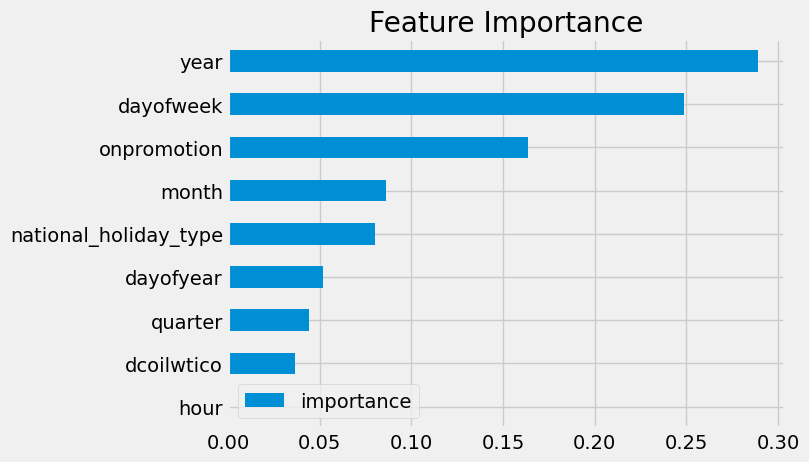

In [38]:
fi = pd.DataFrame(data= reg.feature_importances_,
             index = reg.feature_names_in_,
            columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title ='Feature Importance')

In [39]:
fig = px.line(grouped_df, x=grouped_df.index , y=['sales', 'predictions'])
fig.update_layout(title='Sale and Date Plot')
fig.show()

[0]	validation_0-rmse:641.04490	validation_1-rmse:661.45157
[100]	validation_0-rmse:85.71834	validation_1-rmse:97.64188
[200]	validation_0-rmse:69.76583	validation_1-rmse:99.59689
[300]	validation_0-rmse:59.29784	validation_1-rmse:101.22472
[400]	validation_0-rmse:51.91683	validation_1-rmse:102.62841
[500]	validation_0-rmse:46.26908	validation_1-rmse:103.01200
[600]	validation_0-rmse:41.95925	validation_1-rmse:103.91753
[700]	validation_0-rmse:38.57569	validation_1-rmse:104.64988
[800]	validation_0-rmse:34.85952	validation_1-rmse:105.59504
[900]	validation_0-rmse:31.71191	validation_1-rmse:106.09244
[1000]	validation_0-rmse:29.38189	validation_1-rmse:106.75088
[1100]	validation_0-rmse:26.86385	validation_1-rmse:107.11004
[1200]	validation_0-rmse:25.02126	validation_1-rmse:107.27030
[1300]	validation_0-rmse:23.00811	validation_1-rmse:107.40299
[1400]	validation_0-rmse:21.49907	validation_1-rmse:107.73728
[1500]	validation_0-rmse:20.14272	validation_1-rmse:107.92886
[1600]	validation_0-r

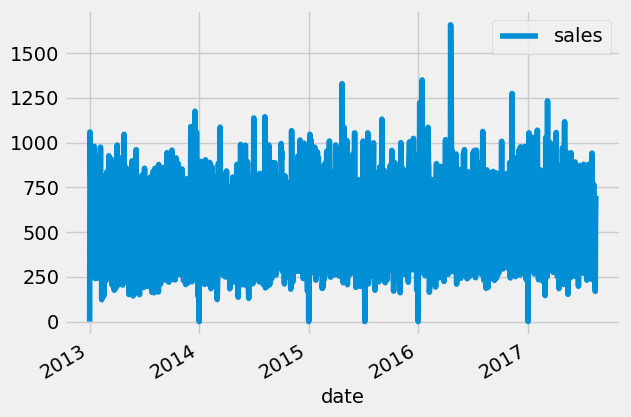

In [40]:
# for store in train_df['store_nbr'].unique():  
temp_df = train_df.query('store_nbr =='+str(1)+' and family==7')
temp_df = temp_df.set_index('date')
temp_df[['sales']].plot()

create_features(temp_df)

FEATURES = ['onpromotion','dcoilwtico', 'national_holiday_type', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']

TARGET = 'sales'

train = temp_df.loc[grouped_df.index < '02-01-2017']
test = temp_df.loc[grouped_df.index >= '02-01-2017']
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           max_depth=5,
                           learning_rate=0.05)

reg2.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

train = temp_df[FEATURES]
temp_df['predictions'] = reg2.predict(train)

fig = px.line(temp_df, x=grouped_df.index , y=['sales', 'predictions'])
fig.update_layout(title='Sale and Date Plot')
fig.show()

In [41]:
del grouped_df['predictions']
grouped_df.describe()

sales   dcoilwtico  onpromotion  national_holiday_type    hour  \
count  1.684000e+03  1684.000000   1684.00000            1684.000000  1684.0   
mean   6.375564e+05    67.893530   4638.13658               0.248219     0.0   
std    2.344102e+05    25.692307   5418.61702               0.914739     0.0   
min    2.511619e+03    26.190000      0.00000               0.000000     0.0   
25%    4.427115e+05    46.378333      0.00000               0.000000     0.0   
50%    6.321889e+05    53.301667   2300.00000               0.000000     0.0   
75%    7.859455e+05    95.785000   8397.25000               0.000000     0.0   
max    1.463084e+06   110.620000  26861.00000               6.000000     0.0   

         dayofweek      quarter        month         year    dayofyear  
count  1684.000000  1684.000000  1684.000000  1684.000000  1684.000000  
mean      2.997031     2.410333     6.207838  2014.837886   173.388955  
std       2.001334     1.100278     3.386673     1.345917   103.469470  
min       0.000000     1.000000     1.000000  2013.000000     1.000000  
25%       1.000000     1.000000     3.000000  2014.000000    85.000000  
50%       3.000000     2.000000     6.000000  2015.000000   169.000000  
75%       5.000000     3.000000     9.000000  2016.000000   259.250000  
max       6.000000     4.000000    12.000000  2017.000000   366.000000

In [42]:
scaler  = MinMaxScaler()
scaled_grouped_df = scaler.fit_transform(grouped_df)
scaled_grouped_df.shape

(1684, 10)

In [43]:
features = scaled_grouped_df
target = scaled_grouped_df[:,0]

features.shape

(1684, 10)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state= 4, shuffle= False)

In [45]:
win_length = 50
batch_size = 32
input_features = X_train.shape[1]

train_generator = TimeseriesGenerator(X_train, y_train, length =win_length,
                    sampling_rate =1, batch_size =batch_size)
test_generator = TimeseriesGenerator(X_test, y_test, length =win_length,
                    sampling_rate =1, batch_size =batch_size)

In [46]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(units=128, return_sequences=True,input_shape=[win_length, input_features]))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(units=64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           71168     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 50, 128)           0         
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [47]:
model.compile(loss= tf.losses.MeanSquaredError(),
             optimizer= tf.optimizers.Adam(),
             metrics =[tf.metrics.MeanAbsoluteError()])


history = model.fit(train_generator, epochs =50,
                              validation_data= test_generator,
                              shuffle = False)

Epoch 1/50
46/46 [==============================] - 27s 194ms/step - loss: 0.0316 - mean_absolute_error: 0.1427 - val_loss: 0.0221 - val_mean_absolute_error: 0.1065
Epoch 2/50
46/46 [==============================] - 4s 85ms/step - loss: 0.0210 - mean_absolute_error: 0.1129 - val_loss: 0.0380 - val_mean_absolute_error: 0.1569
Epoch 3/50
46/46 [==============================] - 4s 86ms/step - loss: 0.0203 - mean_absolute_error: 0.1129 - val_loss: 0.0277 - val_mean_absolute_error: 0.1252
Epoch 4/50
46/46 [==============================] - 4s 87ms/step - loss: 0.0185 - mean_absolute_error: 0.1080 - val_loss: 0.0180 - val_mean_absolute_error: 0.0932
Epoch 5/50
46/46 [==============================] - 5s 101ms/step - loss: 0.0198 - mean_absolute_error: 0.1129 - val_loss: 0.0182 - val_mean_absolute_error: 0.0938
Epoch 6/50
46/46 [==============================] - 5s 101ms/step - loss: 0.0201 - mean_absolute_error: 0.1138 - val_loss: 0.0210 - val_mean_absolute_error: 0.1029
Epoch 7/50
46/46 [

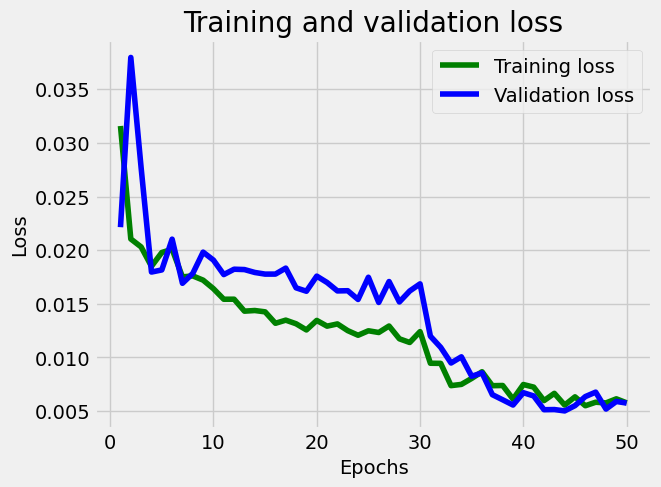

In [48]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss over epochs
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
model.evaluate(test_generator, verbose = 0)

[0.005748832132667303, 0.055583465844392776]

In [50]:
predictions = model.predict(test_generator)

4/4 [==============================] - 4s 60ms/step


In [51]:
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(X_test[:,1:][win_length:])], axis = 1)
rev_trans = scaler.inverse_transform(df_pred)

In [52]:
df_final = grouped_df[predictions.shape[0]*-1:].copy()

In [53]:
df_final.count()

sales                    119
dcoilwtico               119
onpromotion              119
national_holiday_type    119
hour                     119
dayofweek                119
quarter                  119
month                    119
year                     119
dayofyear                119
dtype: int64

In [54]:
df_final['predictions'] = rev_trans[:,0]

<Axes: xlabel='date'>

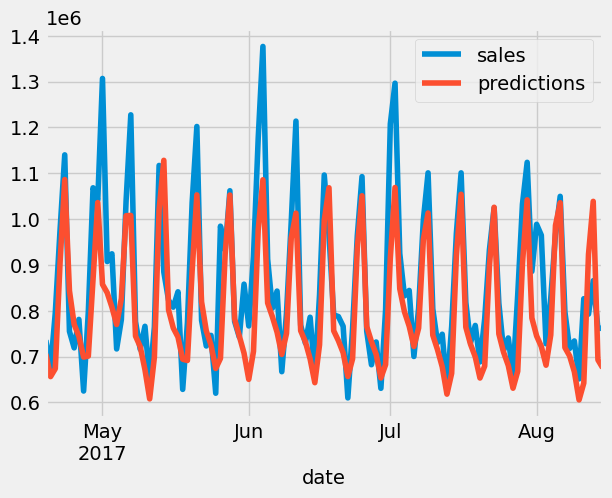

In [55]:
df_final[['sales','predictions']].plot()